# **Transfer Learning with TensorFlow Part 2 : Fine-Tuning**

Reference: https://github.com/mrdbourke/tensorflow-deep-learning

In the previous notebook, we covered transfer learning feature extrction, now it's time to learn about a new kind of transfer learning: fine-tuning

## **Table of Content**

<a id="toc"></a>
- [1. Check your device and version](#1)
- [2. Creating helper functions](#2)

<a id="1"></a>
## **Check your device and version**

In [1]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-05-27 15:26:34.020886


In [2]:
# Are we using a GPU?
!nvidia-smi

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat May 27 15:26:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   47C    P2    74W / 300W |    996MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+----------------------------

```
Tue May 23 09:26:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:03:00.0 Off |                  Off |
| 30%   31C    P8     8W / 300W |  47810MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1315      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A      9270      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     15698      G   /usr/lib/xorg/Xorg                  4MiB |
|    0   N/A  N/A     51864    C+G   ...ome-remote-desktop-daemon      261MiB |
|    0   N/A  N/A     81175      C   ...11__python_3.9/bin/python    47531MiB |
+-----------------------------------------------------------------------------+
```

In [3]:
import os
print("posix = Linux, nt = windows, java = java")
print("your os name is",os.name)

import platform
print("your os is ",platform.system()+platform.release())

from platform import python_version
print("python version is",python_version())

import tensorflow as tf
print("TensorFlow version is",tf.__version__)

print("Are we using a GPU?",len(tf.config.experimental.list_physical_devices('GPU'))>0)

posix = Linux, nt = windows, java = java
your os name is posix
your os is  Linux5.19.0-42-generic
python version is 3.9.16
TensorFlow version is 2.8.3
Are we using a GPU? True


* posix = Linux, nt = windows, java = java
* your os name is posix
* your os is  Linux5.19.0-42-generic
* python version is 3.9.16
* TensorFlow version is 2.8.3
* Are we using a GPU? True

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
## **Creating helper functions**

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# for linux command
if os.path.exists("helper_functions.py") != True:
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# for windows command
# import wget
# if os.path.exists("helper_functions.py") != True:
#     wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')

In [5]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## **Let's get some data**

This time we're going to see how we can use the pretrained models whithin `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [6]:
# Get 10% of training data of 10 classes of Food101

# for linux command
if os.path.exists("10_food_classes_10_percent.zip") != True:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # for windows
# import wget

# if os.path.exists("10_food_classes_10_percent.zip") != True:
#     wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip')
#     print("Download Scucess")


unzip_data("10_food_classes_10_percent.zip")

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-05-27 15:26:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
正在查找主機 storage.googleapis.com (storage.googleapis.com)... 2404:6800:4012:2::2010, 2404:6800:4012:4::2010, 2404:6800:4012:1::2010, ...
正在連接 storage.googleapis.com (storage.googleapis.com)|2404:6800:4012:2::2010|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 168546183 (161M) [application/zip]
儲存到：‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  28.2MB/s    於 6.1s     

2023-05-27 15:27:06 (26.2 MB/s) - 已儲存 ‘10_food_classes_10_percent.zip’ [168546183/168546183]



In [7]:
# Clear any logs from previous runs
# 如果要刪除資料夾可以輸入這個指令
# !rm -rf ./10_food_classes_10_percent.zip/ # linux
# !rd /s /q 10_food_classes_10_percent.zip  # windows

# # 如果要刪除檔案可以輸入這個指令
# # for windows
# !del /s /q "10_food_classes_10_percent.zip"

# for linux
!rm -rf 10_food_classes_10_percent.zip

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [8]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [9]:
# Create training and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [10]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
# Check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    tf.print(images,labels)

[[[[35.3265305 25.3265305 24.3265305]
   [38.1428566 28.1428585 27.1428585]
   [40.7091827 28.7091827 28.7091827]
   ...
   [80.2093 211.918442 135.27565]
   [81.9744339 213.377502 137.377502]
   [82.1277 213.301224 138.714462]]

  [[33.9285736 23.9285717 21.9285717]
   [36.9898 26.9897957 25.9897957]
   [34.5 22.5 22.5]
   ...
   [77.9388046 205.984711 130.540878]
   [83.2653275 211.28064 136.275528]
   [87.3571777 215.433716 140.408203]]

  [[31.7244911 21.5102043 19.5102043]
   [34.627552 23.627552 21.627552]
   [34.2142868 22.3826542 22.0459194]
   ...
   [79.9795761 205.979584 132.193863]
   [79.4133 205.4133 131.627594]
   [81.2856445 207.285645 133.499924]]

  ...

  [[13.8521576 22.8521576 37.8521576]
   [13.9540863 25.9540863 41.5255585]
   [12.8112078 25.0254936 41.2397804]
   ...
   [8 8 10]
   [8 8 10]
   [8 8 10]]

  [[19.6224308 28.6224308 45.6224327]
   [15.9897938 27.9897938 43.9897957]
   [16.8980045 28.3265781 46.540863]
   ...
   [8 8 10]
   [8 8 10]
   [8 8 10]]

  

## **Model 0: Building a transfer learning feature extraction model using the Keras Functional API**

The sequential API is straight-forward, it runs our layers in sequential order

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [14]:
# 1. Create base model with tf.keras.app
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models

# 2. Freeze the base model (so the underlying pre-trained patterns are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# (you don't have to for EfficientNet(s), because there is rescaling layer in EfficientNet model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_feature_extraction")])


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230527-152720
Epoch 1/5


2023-05-27 15:27:23.462764: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-27 15:27:23.463056: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 5s 89ms/step - loss: 1.9549 - accuracy: 0.3707 - val_loss: 1.4060 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 1s 63ms/step - loss: 1.1635 - accuracy: 0.7413 - val_loss: 0.9717 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - 1s 62ms/step - loss: 0.8457 - accuracy: 0.7960 - val_loss: 0.7982 - val_accuracy: 0.8141
Epoch 4/5
24/24 [==============================] - 2s 64ms/step - loss: 0.6940 - accuracy: 0.8347 - val_loss: 0.7055 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 2s 62ms/step - loss: 0.5927 - accuracy: 0.8640 - val_loss: 0.6560 - val_accuracy: 0.8355


In [15]:
model_0.evaluate(test_data)

79/79 [==============================] - 3s 37ms/step - loss: 0.6160 - accuracy: 0.8412


[0.6159906983375549, 0.8411999940872192]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [17]:
# How about we get a summary of the base model?

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [18]:
# How about we get a summary of our whole model?

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


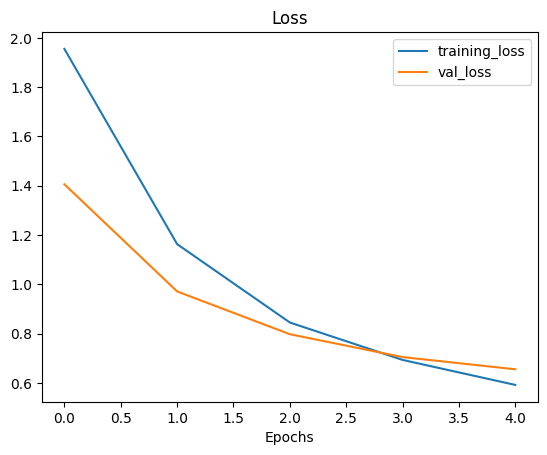

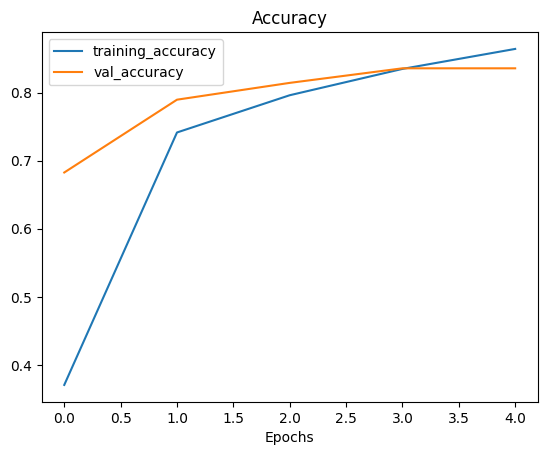

In [19]:
# Check out our model's training cureve

plot_loss_curves(history_10_percent)

## **Getting a feature vector from a trained model**

Let's demonstrate the Golbal Average Pooling 2D Layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it truns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [20]:
# Define the input shape
input_shape = (1,2,2,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")


# Check the shape of the different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of input tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]]

  [[-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]]]

2D global average pooled random tensor:
[[-0.3371175  -1.0493976   0.17876767]]

Shape of input tensor:(1, 2, 2, 3)
Shape of input tensor:(1, 3)


In [21]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.3371175 , -1.0493976 ,  0.17876767]], dtype=float32)>

經過了2D global average pooled 其實就是feature extraction，AI會知道每個數值代表的意思

>🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

In [22]:
# 1. Create base model with tf.keras.app
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models

# 2. Freeze the base model (so the underlying pre-trained patterns are not update during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# (you don't have to for EfficientNet(s), because there is rescaling layer in EfficientNet model)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. max pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalMaxPool2D(name = "global_max_pooling_layer")(x)
print(f"Shape after GlobalMaxPool2D:{x.shape}")


x = tf.keras.layers.Dense(2048,activation = "relu", name = "fully_connection_1")(x)


# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_feature_extraction")])


Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalMaxPool2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230527-152736
Epoch 1/5
24/24 [==============================] - 4s 82ms/step - loss: 15.4360 - accuracy: 0.2760 - val_loss: 1.2849 - val_accuracy: 0.6530
Epoch 2/5
24/24 [==============================] - 2s 64ms/step - loss: 1.2501 - accuracy: 0.6573 - val_loss: 0.7361 - val_accuracy: 0.7566
Epoch 3/5
24/24 [==============================] - 2s 63ms/step - loss: 0.4935 - accuracy: 0.8427 - val_loss: 0.6629 - val_accuracy: 0.7829
Epoch 4/5
24/24 [==============================] - 2s 64ms/step - loss: 0.3212 - accuracy: 0.9093 - val_loss: 0.6892 - val_accuracy: 0.7714
Epoch 5/5
24/24 [==============================] - 2s 64ms/step - loss: 0.2301 - accuracy: 0.9347 - val_loss: 0.6755 - val_accuracy: 0.7944


## **Running a series of transfer learning experiments**

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the raining data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction trasfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tunning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across

### **Getting and preprocessing data for model_1**

In [23]:
# Download and unzip data

# for linux command
if os.path.exists("10_food_classes_1_percent.zip") != True:
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# for windows command
# if os.path.exists("10_food_classes_1_percent.zip") != True:
#     wget.download('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip')

unzip_data("10_food_classes_1_percent.zip")

In [45]:
# Clear any logs from previous runs
# 如果要刪除資料夾可以輸入這個指令
# !rm -rf ./10_food_classes_1_percent.zip/ # linux
# !rd /s /q 10_food_classes_1_percent.zip  # windows

# # 如果要刪除檔案可以輸入這個指令
# # for windows
# !del /s /q "10_food_classes_1_percent.zip"

# for linux
!rm -rf 10_food_classes_1_percent.zip

/bin/bash: /home/chioujryu/anaconda3/envs/tf_2.8.3__python_3.9/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [24]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [25]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [26]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_1_percent,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### **Adding data augmentation right into the model**

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers()` - https://www.tensorflow.org/api_docs/python/tf/keras/layers

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

Off the top our of head, after reading the docs, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.
* If you use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), you will use CPU to generate your data.

In [27]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc...
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2), 
    #tf.keras.layers.Rescaling(scale=1./255), # keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
],name = "data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)



In [28]:
# check the class names
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

10_food_classes_1_percent/train/fried_rice
[[[113  43   9]
  [107  37   1]
  [110  36   1]
  ...
  [244 223 192]
  [244 223 192]
  [244 223 192]]

 [[106  33   0]
  [123  50  15]
  [149  75  38]
  ...
  [245 224 193]
  [245 224 193]
  [245 224 193]]

 [[138  64  27]
  [166  92  53]
  [198 120  81]
  ...
  [246 225 196]
  [246 227 197]
  [246 227 197]]

 ...

 [[151  76  44]
  [134  59  27]
  [152  77  45]
  ...
  [ 61  23   4]
  [ 65  27   8]
  [ 63  25   6]]

 [[137  63  28]
  [141  67  32]
  [162  86  52]
  ...
  [ 59  20   3]
  [ 63  24   7]
  [ 61  22   5]]

 [[131  57  20]
  [148  74  37]
  [165  89  55]
  ...
  [ 59  20   3]
  [ 62  23   6]
  [ 61  22   5]]]
tf.Tensor(
[[[147.33774   102.08548    19.328648 ]
  [156.08858   103.10194    16.359837 ]
  [176.44196   114.170334   19.140682 ]
  ...
  [ 75.29139    24.36089     3.2160442]
  [ 78.89847    27.488214    6.504016 ]
  [ 84.0764     31.26735    11.776467 ]]

 [[182.08344   139.7427     49.569447 ]
  [182.0671    132.56813    

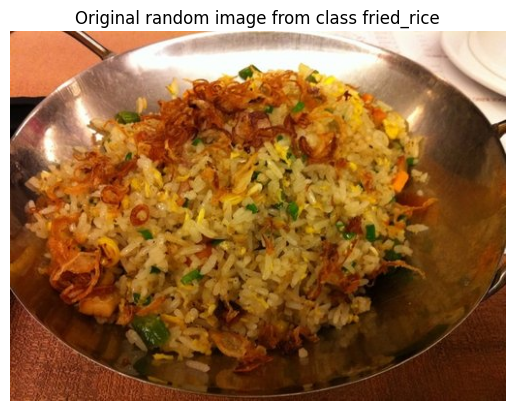

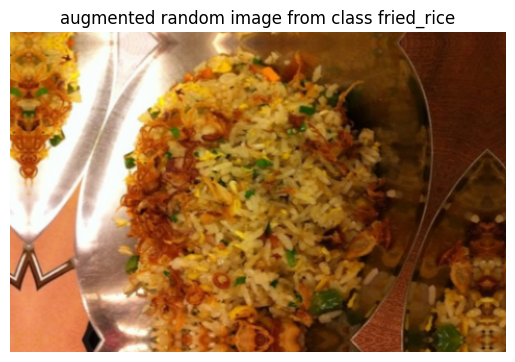

In [29]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
randim_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(randim_image_path)
print(img)
plt.axis(False)
plt.title(f"Original random image from class {target_class}")
plt.imshow(img)

# Now let's plot our augmented random image
augmented_image = data_augmentation(img, training = True)
print(augmented_image)
plt.figure()
plt.axis(False)
plt.title(f"augmented random image from class {target_class}")
plt.imshow(augmented_image.numpy().astype(int))


(212, 258, 3)
(243, 180, 3)
(195, 188, 3)
(179, 204, 3)
(229, 225, 3)
(264, 235, 3)
(196, 184, 3)
(184, 241, 3)
(200, 228, 3)


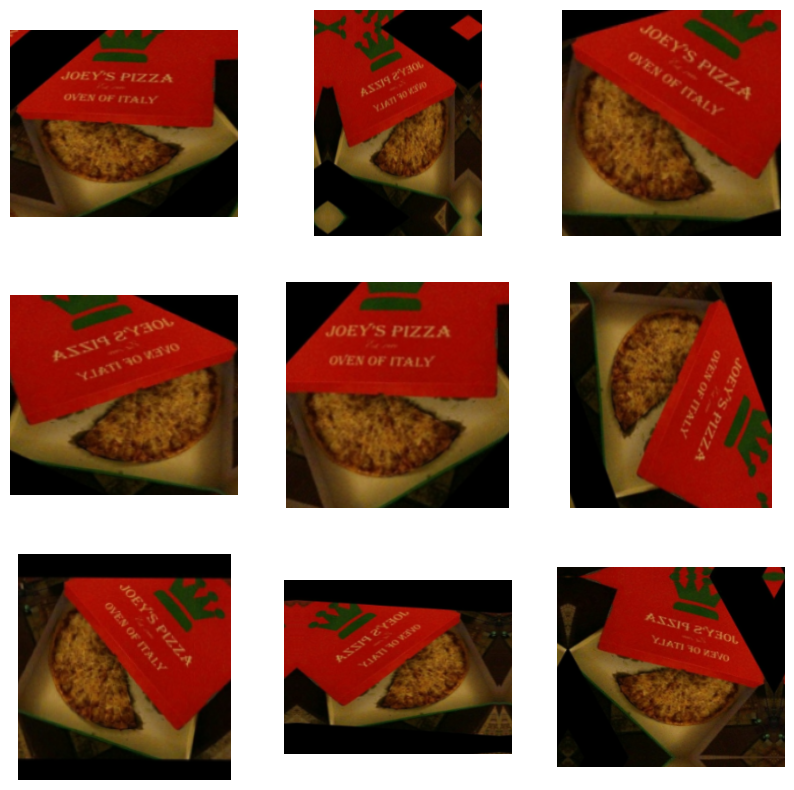

In [30]:
# 也可以一次做資料擴增好幾張
for image, _ in train_data_1_percent.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(first_image,training = True)   # 如果需要增加維度，可以寫 `tf.expand_dims(img, 0).shape`
    print(augmented_image.shape)
    plt.imshow(augmented_image / 255) 
    plt.axis('off')

## **Model 1 : Feature extraction trasfer learning on 1% of the data with data augmentation**

In [31]:
tf.keras.Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [32]:
# Setup input shape and base model, freezing the base model layer

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)    # model is in user/user/.keras/models
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the input (after augmentation) and don't train it
x = base_model(x, training=False)    # Very similar with `base_model.trainable = False`, jsut rewrite it down here

# Pool output feature of the base 
# If it's just a layer, x will be placed at the very side, but if it's a sequential model, 
# x will be placed inside the brackets.
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dnese layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model using the inputs and output
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# Fit the model and save its history
history_1_percent = model_1.fit(train_data_1_percent,
                                 epochs = 10,
                                 steps_per_epoch = len(train_data_1_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                 callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "1_percent_data_augmentation")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_augmentation/20230527-152752
Epoch 1/10
3/3 [==============================] - 3s 684ms/step - loss: 2.3972 - accuracy: 0.0429 - val_loss: 2.2310 - val_accuracy: 0.1678
Epoch 2/10
3/3 [==============================] - 1s 457ms/step - loss: 2.1163 - accuracy: 0.2286 - val_loss: 2.1201 - val_accuracy: 0.2270
Epoch 3/10
3/3 [==============================] - 1s 448ms/step - loss: 1.9562 - accuracy: 0.4286 - val_loss: 2.0207 - val_accuracy: 0.2780
Epoch 4/10
3/3 [==============================] - 1s 449ms/step - loss: 1.7687 - accuracy: 0.5714 - val_loss: 1.9252 - val_accuracy: 0.3322
Epoch 5/10
3/3 [==============================] - 1s 421ms/step - loss: 1.5969 - accuracy: 0.6429 - val_loss: 1.8455 - val_accuracy: 0.4030
Epoch 6/10
3/3 [==============================] - 1s 419ms/step - loss: 1.4459 - accuracy: 0.7143 - val_loss: 1.7555 - val_accuracy: 0.4391
Epoch 7/10
3/3 [==============================] - 1s 426ms/step -

In [33]:
# Check out a model summary

model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [34]:
# Evuluate all test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 3s 35ms/step - loss: 1.5009 - accuracy: 0.5860


[1.50091552734375, 0.5860000252723694]

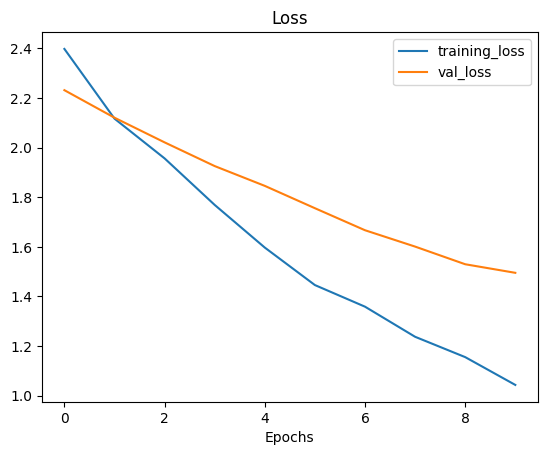

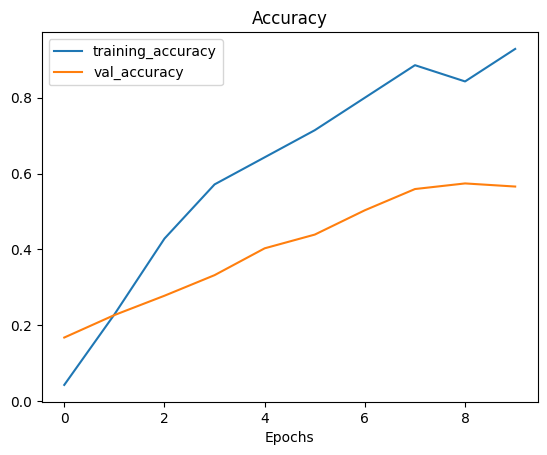

In [35]:
# How do the model with 1% of the and data augmentation loss curves look?

plot_loss_curves(history_1_percent)

## **Model 2 : Feature extraction trasfer learning on 10% of the data with data augmentation**

In [36]:
# get 10% of data (uncomment if you don't have it)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [37]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(
                                        directory = train_dir_10_percent,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


test_data = tf.keras.utils.image_dataset_from_directory(
                                        directory = test_dir,
                                        labels='inferred',
                                        label_mode='categorical',
                                        class_names=None,
                                        color_mode='rgb',
                                        batch_size = BATCH_SIZE,
                                        image_size = IMG_SIZE,
                                        shuffle=True,
                                        seed=None,
                                        validation_split=None,
                                        subset=None,
                                        interpolation='bilinear',
                                        follow_links=False,
                                        crop_to_aspect_ratio=False,
                                    )


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [38]:
# How many images are in our directory
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [39]:
# check the file structure
import os

def list_files(startpath, show_file = False):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        if show_file == True:
            for f in files:
                print('{}{}'.format(subindent, f))

list_files("10_food_classes_10_percent", show_file = False)

10_food_classes_10_percent/
    test/
        chicken_wings/
        fried_rice/
        sushi/
        steak/
        ramen/
        chicken_curry/
        grilled_salmon/
        hamburger/
        ice_cream/
        pizza/
    train/
        chicken_wings/
        fried_rice/
        sushi/
        steak/
        ramen/
        chicken_curry/
        grilled_salmon/
        hamburger/
        ice_cream/
        pizza/


In [40]:
# Create model 2 with data augmentation built in

# Build data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.Rescaling(scale=1./255) # if you are using a model such as ResNet,  you'll need to rescale your data, efficientnet has rescaling built-in
], name= "data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a fronzen base model (alse called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs, training = True)   # augment our training image (augmentation doesn't occur on test data)

# pass augmented image to base model but keep it in inference mode, this also insures BatchNormalization layers don't get updated
# https://keras.io/guides/transfer_learning/#build-a-model
x = base_model(x, training = False) 

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss = "categorical_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [41]:
# from top to bottom: input_layer -> data_augmentation -> EfficientNetB0. 
# The input_layer serves as the input to the data_augmentation layer, 
# and the output of data_augmentation is then passed to the EfficientNetB0 model.
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### **Creating a ModelCheckpoint callback**

The ModelCheckpoint callback intermediately saves our model(the full model or just the weight)

In [60]:
# set checkpoint path
checkpoint_path = "10_percent_model_checkpoint_weights/checkpoint.ckpt"

# create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                            filepath = checkpoint_path,
                                                            monitor = 'val_loss',
                                                            verbose = 1,
                                                            save_best_only = False,
                                                            save_weights_only = True,
                                                            mode = 'auto',
                                                            save_freq='epoch',  
                                                            options=None,
                                                            initial_value_threshold=None,
                                                        )

### **Fit model 2 passing the the ModelCheckpoint callback**

In [61]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5

# Fit the model and save its history
hirstory_10_percent_data_augmentation = model_2.fit(train_data_10_percent,
                                        epochs = initial_epochs,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = int(0.25 * len(test_data)), # Only 25% of the test data is used because using 100% of the test data for each epoch would take too long.
                                        callbacks=[create_tensorboard_callback(dir_name ="transfer_learning",experiment_name = "10_percent_data_augmentation"),
                                                   checkpoint_callback ])  # 


Saving TensorBoard log files to: transfer_learning/10_percent_data_augmentation/20230527-154631
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.7394 - accuracy: 0.7987
Epoch 1: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 3s 129ms/step - loss: 0.7394 - accuracy: 0.7987 - val_loss: 0.7711 - val_accuracy: 0.7697
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.8240
Epoch 2: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 3s 129ms/step - loss: 0.6803 - accuracy: 0.8240 - val_loss: 0.7711 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.8280
Epoch 3: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 3s 127ms/step - loss: 0.6344 - accuracy: 0.8280 - val_loss: 0.7233 - val_accuracy: 0.7730
E

In [62]:
# what were model_0 results?

model_0.evaluate(test_data)


79/79 [==============================] - 3s 35ms/step - loss: 0.7125 - accuracy: 0.7816


[0.7125268578529358, 0.7815999984741211]

In [63]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 62ms/step - loss: 0.7011 - accuracy: 0.7852


[0.7010787129402161, 0.7851999998092651]

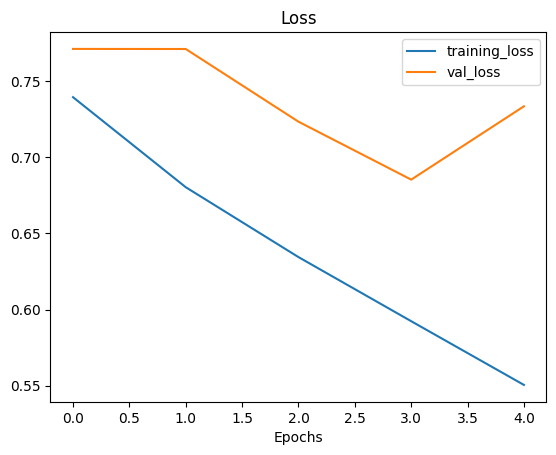

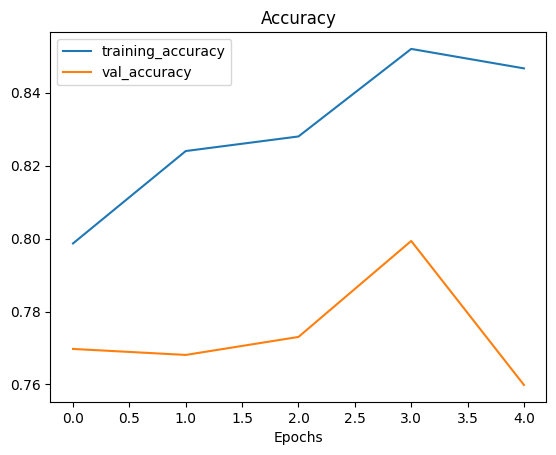

In [64]:
# Plot model loss curves
plot_loss_curves(hirstory_10_percent_data_augmentation)

### Losding in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [65]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [66]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.6997 - accuracy: 0.7836


In [67]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [68]:
# Check to see if loaded model results are very close to our previous non-laoded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([False, False])

In [70]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0.00138587 0.00160003]
